In [55]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import datetime


In [56]:
# Define some constants
latitude = [40.79736, 41.78701, 30.1444, 25.7738]
longitude = [-73.97785, -87.77166, -97.66876, -80.1936]
cities = ["ny", "il", "tx", "fl"]
start_date = "2016-01-01"
end_date = "2024-03-20"
city = cities[3]

In [57]:
# Step 1: Load your data
# Assume 'df' is your DataFrame with columns 'date', 'day_of_year', 'tmax', 'tmin', 'precipitation', 'humidity'
df = pd.read_pickle("./Data/data_cleaned_"+ city +".pkl")
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
# df.loc[datetime.datetime(2016, 1, 1), datetime.datetime(2024, 2, 29)]
df

,tmax_vc,tmax_om,tmax_ms,tmax_ncei,humi_vc,prec_om,tmin_ms,tmin_ncei,day,tmax_avg,tmin_avg
date,,,,,,,,,,,
2016-01-01,83.7,81.308300,84.02,83.0,79.2,1.0,73.94,74.0,1,83.009433,73.94
2016-01-02,82.9,79.328298,84.02,83.0,79.2,9.0,71.06,70.0,2,82.082766,71.06
2016-01-03,78.6,76.718300,78.98,82.0,85.8,7.0,64.94,68.0,3,78.099433,64.94
2016-01-04,70.7,73.928298,71.06,82.0,66.5,3.0,60.98,62.0,4,71.896099,60.98
2016-01-05,72.0,71.498300,71.96,72.0,67.3,0.0,60.08,58.0,5,71.819433,60.08
...,...,...,...,...,...,...,...,...,...,...,...
2024-03-15,82.4,82.016598,82.94,82.0,69.1,0.0,73.04,69.0,75,82.452199,73.04
2024-03-16,85.7,83.546600,86.00,83.0,75.9,0.0,69.98,70.0,76,85.082200,69.98
2024-03-17,85.1,83.006600,87.08,86.0,75.3,12.0,71.96,72.0,77,85.062200,71.96


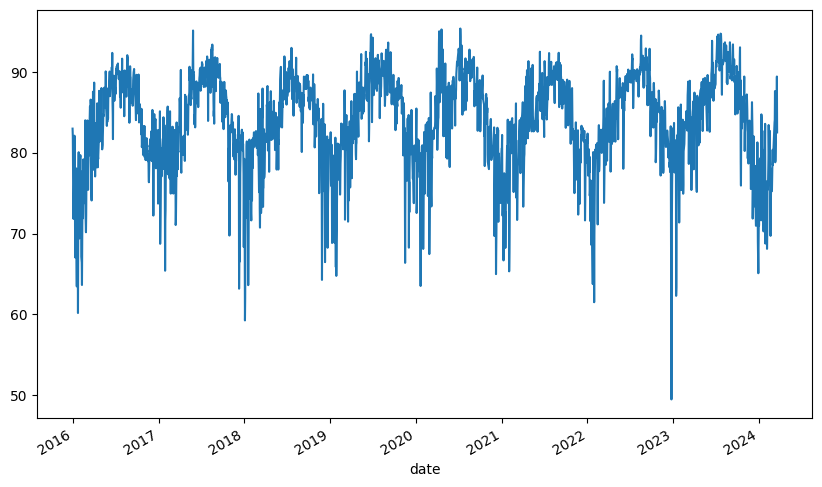

In [58]:
df['tmax_avg'].plot(figsize=(10,6))
plt.show()


In [59]:
df = df.rename(columns={"day": "day_of_year", "tmax_avg":"tmax", "tmin_avg": "tmin", 'prec_om': "prec", 'humi_vc': "humi"})
df.info()
features = ['day_of_year', 'tmax', 'tmin', 'prec', 'humi']
df = df[features]


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2783 entries, 2016-01-01 to 2024-03-19
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   tmax_vc      2783 non-null   float64
 1   tmax_om      2783 non-null   float64
 2   tmax_ms      2783 non-null   float64
 3   tmax_ncei    2754 non-null   float64
 4   humi         2783 non-null   float64
 5   prec         2783 non-null   float64
 6   tmin_ms      2783 non-null   float64
 7   tmin_ncei    2765 non-null   float64
 8   day_of_year  2783 non-null   int32  
 9   tmax         2783 non-null   float64
 10  tmin         2783 non-null   float64
dtypes: float64(10), int32(1)
memory usage: 250.0 KB


In [60]:
df

,day_of_year,tmax,tmin,prec,humi
date,,,,,
2016-01-01,1,83.009433,73.94,1.0,79.2
2016-01-02,2,82.082766,71.06,9.0,79.2
2016-01-03,3,78.099433,64.94,7.0,85.8
2016-01-04,4,71.896099,60.98,3.0,66.5
2016-01-05,5,71.819433,60.08,0.0,67.3
...,...,...,...,...,...
2024-03-15,75,82.452199,73.04,0.0,69.1
2024-03-16,76,85.082200,69.98,0.0,75.9
2024-03-17,77,85.062200,71.96,12.0,75.3


In [61]:
df


In [62]:
target = 'tmax'

# Normalize the features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[features])

In [63]:
# Function to create a dataset for LSTM
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)


In [64]:
time_steps = 60  # Use 10 days of data to predict the next day's 'tmax'
X, y = create_dataset(df_scaled, df_scaled[:, 1], time_steps)
split = int(len(X) * 0.75)  # 70% for training

# Split the data
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [65]:
# LSTM model
model = Sequential()
model.add(LSTM(70, activation='relu', input_shape=(time_steps, X.shape[2])))
model.add(Dense(1))
model.compile(optimizer=Adam(0.001), loss='mean_squared_error')


/opt/miniconda3/envs/cs542/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [66]:
# Train the model
model.fit(X_train, y_train, epochs=47, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/47


52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.6227 - val_loss: 0.3298
Epoch 2/47
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.2995 - val_loss: 0.2760
Epoch 3/47
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2604 - val_loss: 0.2655
Epoch 4/47
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2050 - val_loss: 0.2584
Epoch 5/47
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.2312 - val_loss: 0.2236
Epoch 6/47
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1885 - val_loss: 0.2128
Epoch 7/47
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1949 - val_loss: 0.2152
Epoch 8/47
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1786 - val_loss: 0.2111
Epoch 9/47
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1784 - val_loss: 0.2118
Epoch 10/47
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1744 - val_loss: 0.2239
Epoch 11/47
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1998 - val_loss: 0.2160
Epoch 12/47
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1787 - val_l

In [67]:
# Evaluate the model
mse = model.evaluate(X_test, y_test, verbose=0)
print(f'Test MSE: {mse}')
model.save("model_" + city + '.keras')
# Predictions
predictions = model.predict(X_test)

Test MSE: 0.32238879799842834
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [68]:
df_scaled[-5:]

array([[-0.97223361, -0.23426371,  0.16730843, -1.12659623, -0.3986989 ],
       [-0.9628783 ,  0.2236804 , -0.24925451, -1.12659623,  0.42391045],
       [-0.95352298,  0.22019794,  0.02028621,  1.08604831,  0.35132727],
       [-0.94416766,  0.98692041,  0.16730843, -0.20466101, -0.12046339],
       [-0.93481235, -0.21801211,  0.16730843, -0.75782214, -0.93097554]])

In [69]:
# df.iloc[-time_steps:]

In [70]:
# Prepare the input data for March 9, 2024
# This is an example array where you need to replace it with actual data from Feb 27, 2024, to March 8, 2024.
# Each row in `last_days_data` corresponds to a day, with columns for 'day_of_year', 'tmax', 'tmin', 'prec', 'humi'.
last_days_data = np.array(df[-(time_steps-1):])
# print(last_days_data)
# Normalize the input data using the same scaler used for the training data
last_days_scaled = scaler.transform(last_days_data)

# Reshape the data to match the input shape of the LSTM model: (1, time_steps, num_features)
last_days_scaled = np.expand_dims(last_days_scaled, axis=0)

# Predict the scaled 'tmax' for March 9, 2024
predicted_tmax_scaled = model.predict(last_days_scaled)

# Inverse transform the scaled prediction to get the actual temperature
# predicted_tmax = scaler.inverse_transform(np.concatenate((np.zeros((predicted_tmax_scaled.shape[0], df_scaled.shape[1]-1)), predicted_tmax_scaled), axis=1))[:, 1]
# Step 1: Create a dummy array with the same structure as the training data
dummy_array = np.zeros((1, len(features)))  # 'features' should include all features used during scaling

# Step 2: Replace the 'tmax' values in the dummy array with your predictions
# Assuming 'tmax' was the second feature during scaling
dummy_array[:, 1] = predicted_tmax_scaled  # Replace '1' with the correct index of 'tmax' in your features

# Step 3: Apply the inverse transformation
inverse_transformed_array = scaler.inverse_transform(dummy_array)

# Step 4: Extract the inverse-transformed 'tmax' values
predicted_tmax = inverse_transformed_array[:, 1]  # Use the correct index for 'tmax'

print(predicted_tmax)
print(f"Predicted 'tmax' for next day: {predicted_tmax[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
[80.61674858]
Predicted 'tmax' for next day: 80.61674858094288


/opt/miniconda3/envs/cs542/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
